# AI for Transportation | Recitation 4: Generative AI for Urban Planning  

In this recitation, we explore how conditional diffusion models, specifically **ControlNet**, can be used to generate urban imagery under structured constraints. Our goal is to see how modern generative AI models can combine **text prompts** with **spatial condition images** to synthesize layouts that are both realistic and aligned with planning objectives.

We will walk through three main steps:  

1. **Model Setup:** Loading pretrained ControlNet weights and initializing the inference pipeline.  
2. **Conditioned Generation:** Using a control image (e.g., a land-use or road network map) alongside a textual description to guide the diffusion process.  
3. **Evaluation:** Adjusting key parameters such as diffusion steps, guidance scale, and control strength, and comparing generated outputs with ground truth imagery.

Through this exercise, you will see how generative AI pipelines are built for urban planning tasks, develop intuition about the trade-offs between realism and adherence to constraints, and reflect on possible applications for design, analysis, and research.

In [ ]:
# Setup (only once per Colab runtime)
# --- Install dependencies ---
!pip install -q open_clip_torch pytorch-lightning==1.9.5 torchmetrics==0.11.4 \
                einops omegaconf opencv-python-headless imageio transformers \
                safetensors

# --- Clone ControlNet repo ---
!git clone https://github.com/lllyasviel/ControlNet.git /content/ControlNet

# --- Add repo to Python path ---
import sys, os, gc, torch
sys.path.append("/content/ControlNet")  # needed for cldm imports

# --- Imports ---
import cv2
import einops
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from safetensors.torch import load_file as load_safetensors

from cldm.model import create_model
from cldm.ddim_hacked import DDIMSampler

print("cldm import OK")

# --- Device setup ---
# Reduce fragmentation and clear caches before model allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)

print("Using device:", device)

fatal: destination path '/content/ControlNet' already exists and is not an empty directory.
cldm import OK
Using device: cuda


If you see "Using device: cpu", we recommend switching your runtime to use a T4 GPU. Google Colab offers these for free up to a certain monthly limit. For setup guidance, see the [Colab GPU documentation](https://cloud.google.com/colab/docs/default-runtimes-with-gpus#enable).

## Model Loading

In this step, we download the resources needed for the exercise.  
- **Model files:** the pretrained ControlNet checkpoint (`.safetensors`) and its configuration file (`.yaml`).  
- **Data files:** a *hint image* (used as the structural condition to guide generation) and a *ground truth image* (used later for comparison).  

We then set the corresponding file paths so they can be used throughout the notebook.

In [ ]:
MODEL_DIR = './model/'
DATA_DIR = './model/'

!gdown 1hO409B3i3kOWAspsSIfof7FogSnk1RNX -O "{MODEL_DIR}"   # Model checkpoint
!gdown 1Fgb3Cofs6Mc9mNqXk1BW9Io5Iud2V8un -O "{MODEL_DIR}"   # Model configuration
!gdown 1xv3bfbdl9gtKDJ8XvS3m5zGi8Zn1-uAz -O "{DATA_DIR}"    # Hint TIF
!gdown 1JYzXbUbhspfPB9B4IpSKjUXYSrH8Bq6Z -O "{DATA_DIR}"    # True TIF

Downloading...
From (original): https://drive.google.com/uc?id=1hO409B3i3kOWAspsSIfof7FogSnk1RNX
From (redirected): https://drive.google.com/uc?id=1hO409B3i3kOWAspsSIfof7FogSnk1RNX&confirm=t&uuid=920faee7-186b-4a71-9717-cc75d1f0982a
To: /content/model/urbancontrolnet_t40_ep40_fp16.safetensors
100% 2.86G/2.86G [00:58<00:00, 48.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Fgb3Cofs6Mc9mNqXk1BW9Io5Iud2V8un
To: /content/model/cldm_v15.yaml
100% 1.95k/1.95k [00:00<00:00, 10.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xv3bfbdl9gtKDJ8XvS3m5zGi8Zn1-uAz
To: /content/model/hint.tif
100% 12.2k/12.2k [00:00<00:00, 38.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JYzXbUbhspfPB9B4IpSKjUXYSrH8Bq6Z
To: /content/model/true.tif
100% 17.6k/17.6k [00:00<00:00, 36.3MB/s]


In [ ]:
ckpt_path = MODEL_DIR + "urbancontrolnet_t40_ep40_fp16.safetensors"
conf_path = MODEL_DIR + "cldm_v15.yaml"
hint_path = DATA_DIR + "hint.tif"
true_path = DATA_DIR + "true.tif"
save_path = "output.jpg"

In this cell, we create the ControlNet model and load its pretrained weights. Step by step:

1. **Disable gradients:**  
   `torch.set_grad_enabled(False)` ensures PyTorch does not track gradients, since we are only running inference, not training.

2. **Build the model:**  
   `create_model(conf_path)` constructs the network from the configuration file.  
   - `.to("cuda")` places it on the GPU.  
   - `.half()` casts it to 16-bit floating point to save memory and improve speed.  
   - `.eval()` switches the model into evaluation mode so layers like dropout and batch norm behave deterministically.

3. **Load the state dictionary:**  
   `load_safetensors(ckpt_path, device="cpu")` loads the pretrained weights from a `.safetensors` file into CPU memory.

4. **Match dtypes:**  
   We loop through the weights and, if any floating-point tensors are not fp16, we cast them to fp16 to match the model.

5. **Copy into the model:**  
   `model.load_state_dict(state, strict=False)` copies the weights into the model.  
   `strict=False` allows for minor differences in keys between the checkpoint and the model.  
   Any missing or unexpected keys are reported.

6. **Cleanup:**  
   The `state` dictionary is deleted and Python/torch memory caches are cleared to free up CPU/GPU memory.

The final print statement confirms that the weights were loaded and reports if any keys did not match.

In [ ]:
# ---------- 2) Model loading (reusable) ----------
torch.set_grad_enabled(False)

# 1) Build model on CUDA and set to fp16 before loading
model = create_model(conf_path).to("cuda").half().eval()

# 2) Load full state dict from .safetensors on CPU
state = load_safetensors(ckpt_path, device="cpu")

# 3) Ensure weights match model dtype (fp16) before copying
for k, v in list(state.items()):
    if isinstance(v, torch.Tensor) and v.is_floating_point() and v.dtype != torch.float16:
        state[k] = v.half()

# 4) Load into the already-half CUDA model
missing, unexpected = model.load_state_dict(state, strict=False)
# Ensure that we are
del state; gc.collect(); torch.cuda.empty_cache()

print(f"Loaded. missing={len(missing)}, unexpected={len(unexpected)}")

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./model/cldm_v15.yaml]
Loaded. missing=0, unexpected=1


Now we finalize the setup for inference. `model.eval()` ensures the model runs in evaluation mode, disabling training-specific behavior like dropout. We then create a `DDIMSampler`, which is the diffusion sampler responsible for iteratively denoising latent variables into a final image conditioned on our prompts and control input.  

In [ ]:
model.eval()
sampler = DDIMSampler(model)

## Inference  

With the pretrained model loaded, we can now move directly to the **inference stage**. Here, we define the parameters that set the conditions for the diffusion process—such as the control image, prompts, and sampling settings. These parameters specify both the **constraints** (what the model must follow, like land-use maps or road density) and the **expectations** (the quality and style of the generated output).  

### Parameters

**prompt:**  
The main textual description that guides image generation. In this case, it specifies land-use types and road density for an urban map of New York. The model uses this information as the primary design target.

**a_prompt (positive prompt):**  
Additional descriptive tags that bias the output toward higher quality and detail (e.g., *“best quality, extremely detailed”*). These act as reinforcement to improve visual fidelity.

**n_prompt (negative prompt):**  
Tags of undesired qualities that the model should avoid (e.g., *“cropped, worst quality, low quality”*). This helps steer the output away from common artifacts or poor results.

**num_samples:**  
Number of images generated in a single forward pass. Setting this to 1 creates one candidate output at a time.

**ddim_steps:**  
Number of denoising steps in the diffusion process. Fewer steps make generation faster but may sacrifice sharpness and accuracy. More steps improve quality at the cost of runtime. Typical values are 20–50.

**scale (guidance scale):**  
Controls the balance between following the text prompt and allowing freer generation. A lower value increases creativity but weakens alignment to the prompt. A higher value enforces fidelity to the prompt but may reduce diversity or introduce rigidity. Common values are 7–12.

**eta:**  
Controls randomness in DDIM sampling. At `0.0`, the process is deterministic (same seed → same image). Nonzero values introduce extra noise, producing more varied outputs across runs.

**strength:**  
Determines how strongly the control input (e.g., hint image, edge map) influences the final result. `1.0` enforces strict adherence to the condition, while lower values allow more deviation from the input.

**guess_mode:**  
If `True`, ControlNet relaxes its reliance on the control input and allows the model to "guess" missing details more freely. If `False`, the model closely follows the provided control signal.

In [ ]:
a_prompt    = "best quality, extremely detailed" # positive prompt
n_prompt    = "cropped, worst quality, low quality" # negative prompt
prompt      = """
    Land use types and road network map of New York.
    Land use parcels include
        68.9 percent of residential,
        26.1 percent of commercial,
        0.0 percent of manufacturing,
        4.2 percent of park,
        0.0 percent of mixed use.
    Road density is 0.19.
"""
num_samples = 1
ddim_steps  = 20
scale       = 9.0
eta         = 0.0
strength    = 1.0
guess_mode  = False

This block puts everything together: it takes the **hint image** and the **text prompts**, runs them through ControlNet, and produces a generated output image.

1) **Run in inference mode**  
   - `torch.no_grad()` tells PyTorch we don't need gradients (we're not training).  
   - `torch.autocast(..., dtype=torch.float16)` runs the model in half-precision on the GPU, making it faster and lighter on memory.

2) **Load the hint image**  
   - We load the control image with `cv2.imread`. Sometimes images have an alpha channel (transparency).  
   - If the alpha channel exists, fully transparent pixels are painted white so the model doesn't “see” empty regions.  
   - The image is then reduced to standard 3-channel **BGR**.

3) **Prepare the control tensor**  
   - The height and width of the image are recorded.  
   - We convert the image from **BGR → RGB** and scale pixel values into the range `[0, 1]`.  
   - The image is duplicated for however many samples we want to generate (batching).  
   - Finally, it is reshaped into the format the model expects (`[batch, channels, height, width]`) and moved to the GPU.

4) **Encode the text prompts**  
   - The model's text encoder turns both the main prompt (plus the positive prompt) and the negative prompt into numerical embeddings.  
   - These embeddings are placed into dictionaries (`cond` and `un_cond`) along with the control tensor.  
   - If `guess_mode` is enabled, the unconditional branch does not receive the control tensor, letting the model “guess” more freely.

5) **Set up the latent space**  
   - Images are generated in a compressed “latent space,” 8x smaller than the input size.  
   - We specify this latent shape and also tell ControlNet how strongly it should follow the control input (`strength`).  
   - If `guess_mode=False`, the strength is constant; otherwise, it gradually decreases across the network layers.

6) **Sampling with DDIM**  
   - The `DDIMSampler` iteratively removes noise from the latent representation, guided by both the control image and the text prompts.  
   - The number of steps (`ddim_steps`), guidance scale, and noise factor (`eta`) determine how the image is generated.  
   - More steps = sharper and more detailed images, but also slower.

7) **Decode and save the result**  
   - The model's decoder transforms the final latent representation back into a full-resolution RGB image.  
   - We rescale the values back to `[0, 255]`, convert them into integers, and take the first generated sample.  
   - Finally, we save it to disk as a `.jpg`.

**Result:** this code takes your *map-like hint image* and *text instructions* and, using the pretrained ControlNet, creates a new urban-style image that respects both.

In [ ]:
with torch.no_grad(), torch.autocast(device_type="cuda", dtype=torch.float16):
    detected_map = cv2.imread(hint_path, cv2.IMREAD_UNCHANGED)

    if detected_map.ndim == 3 and detected_map.shape[2] == 4:
        mask = (detected_map[:,:,3] == 0)
        detected_map[mask] = [255,255,255,255]
        detected_map = cv2.cvtColor(detected_map, cv2.COLOR_BGRA2BGR)

    H, W = detected_map.shape[:2]
    control = cv2.cvtColor(detected_map, cv2.COLOR_BGR2RGB)         # BGR→RGB
    control = torch.from_numpy(control.copy()).float() / 255.0      # [H,W,C] in [0,1]
    control = torch.stack([control for _ in range(num_samples)], 0) # [B,H,W,C]
    control = einops.rearrange(control, "b h w c -> b c h w").to(device).contiguous()

    with torch.no_grad():
        cond    = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control],
                "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape   = (4, H//8, W//8)
        model.control_scales = ([strength]*13) if not guess_mode else [strength*(0.825**(12 - i)) for i in range(13)]

        samples, _ = sampler.sample(
            S=ddim_steps, batch_size=num_samples, shape=shape, conditioning=cond,
            verbose=False, eta=eta, unconditional_guidance_scale=scale,
            unconditional_conditioning=un_cond
        )

        # Decode to image and save
        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, "b c h w -> b h w c") * 127.5 + 127.5) \
                    .clamp(0,255).cpu().numpy().astype(np.uint8)
        out = x_samples[0]
        cv2.imwrite(save_path, cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
        print("Saved:", save_path, "| shape:", out.shape)

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Saved: ./model/output.jpg | shape: (512, 512, 3)


## Analysis  

After running inference with the hint image and our chosen prompts, we can now **evaluate the results**. Try to change a few of the parameters. What changes do you see? How would you change the parameters for your specific use case?

In [ ]:
# Load ground truth image and hint image (site constraints)
true_img = cv2.imread(true_path, cv2.IMREAD_COLOR)   # BGR
true_img = cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB) # to RGB

hint_img = cv2.imread(hint_path, cv2.IMREAD_COLOR)   # BGR
hint_img = cv2.cvtColor(hint_img, cv2.COLOR_BGR2RGB) # to RGB

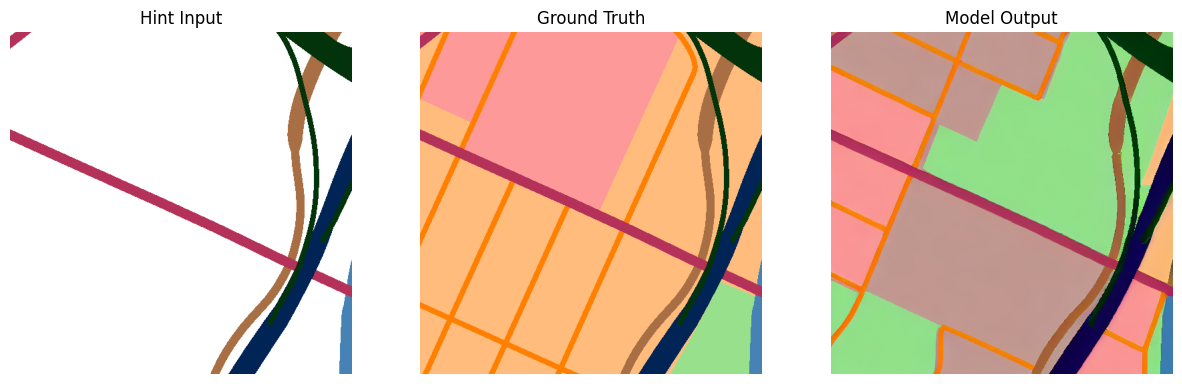

In [ ]:
# Visualization: side by side comparison
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(hint_img)
axs[0].set_title("Hint Input")
axs[0].axis("off")

axs[1].imshow(true_img)
axs[1].set_title("Ground Truth")
axs[1].axis("off")

axs[2].imshow(out)
axs[2].set_title("Model Output")
axs[2].axis("off")

plt.show()

## Results and Insights

If you kept the default settings, the generated output should resemble the provided ground truth fairly well. For example, you may notice that the synthesized road network looks realistic for New York City. This makes sense, since the model was primarily trained on data from that geographic context.  

However, it is interesting to think about how changing the prompts could lead to very different results. A description of a more “European” urban form, for instance, might encourage the model to generate narrower streets, denser blocks, or different land-use distributions.  

At this stage, you are encouraged to **experiment with the parameters**. Adjust the prompts, change the land-use percentages, vary the guidance scale or strength, and observe how the model responds. This helps highlight both the **capabilities** of generative models in capturing urban structure and the **limitations** they face when asked to generalize beyond their training data.

# Where to Go from Here?  

In this recitation, we explored how conditional diffusion models such as **ControlNet** can be used to generate urban imagery under explicit constraints. Before wrapping up, let’s reflect on what these models can contribute to urban planning practice and what directions they open for further research.  

## Generative AI for Urban Design  

With ControlNet, we saw how a model can take both **text prompts** and **condition images** (e.g., road networks, land-use maps) to create outputs that align with urban design goals. Importantly, this is not limited to the example of New York City used in class. Similar approaches could be applied to different geographies, planning objectives, or design stages.  

Practical next steps for urban design and planning include:  
* Exploring **different condition images** (e.g., building footprints, elevation data, or mobility networks) to test how they shape the generated outputs.  
* Varying **prompts and parameters** to balance realism, fidelity to constraints, and creative exploration.  
* Using generative outputs as **communication tools** to engage stakeholders—providing visual material that is intuitive for non-experts and open to feedback.  

## Human-in-the-Loop Design  

One important insight from current research is that generative AI is most powerful when paired with **human expertise**. Rather than replacing planners or designers, diffusion models can act as tools for **iterative refinement**: humans provide goals, constraints, and critiques, while the model generates candidate drafts that can be revised in each cycle.  

This human-centered workflow has several promising directions:  
* Supporting **participatory planning** by generating multiple alternatives for public discussion.  
* Integrating **domain-specific evaluation criteria** (e.g., walkability, access to green space, density targets) into the design loop.  
* Combining **AI-generated visuals with quantitative metrics** to balance creativity with practical feasibility.  

## Research Directions  

From a research perspective, generative AI in urban planning raises exciting questions:  
* How well can models generalize to contexts beyond their training data?  
* What strategies best ensure **compliance with constraints** while maintaining output diversity?  
* How can we evaluate the **quality of designs**, not just visually but also in terms of livability, sustainability, and equity?  

The [Generative Urban Design framework](see attached slides) illustrates how stepwise approaches—progressing from road networks to building layouts to detailed renderings—can improve alignment with human intent and produce higher-quality results than end-to-end generation.  

---

The examples in this recitation are only a starting point. Still, they demonstrate how generative AI can enrich the urban design process, making it more efficient, more participatory, and more creative. Our hope is that this session encourages you to imagine new applications of generative models in your own work and research.

# Acknowledgements

Course TA:
- Riccardo Fiorista ([LinkedIn](https://www.linkedin.com/in/riccardo-fiorista))

Recitation credits:
- Mingyi He ([LinkedIn](https://www.linkedin.com/in/mingyi-he-9782a92b1))
- Yuebing Liang ([LinkedIn](https://www.linkedin.com/in/yuebing-liang-762923182))


Based on the work:
[Generative AI for Urban Planning: Synthesizing Satellite Imagery via Diffusion Models](https://arxiv.org/pdf/2505.08833) by *Qingyi Wang*, *Yuebing Liang*, *Yunhan Zheng*, *Kaiyuan Xu*, *Jinhua Zhao*, *Shenhao Wang*, with code from this [GitHub repository](https://github.com/sunnyqywang/Urban-Control)